In [1]:
# ==========================================================
# STEP 1: Import Required Libraries
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
sns.set()

In [2]:
# ==========================================================
# STEP 2: Load Dataset
# ==========================================================
data = pd.read_csv('ds_salaries.csv')
print("Original shape:", data.shape)

Original shape: (3755, 11)


In [3]:
# ==========================================================
# STEP 3: Select Relevant Columns (safe)
# ==========================================================
cols_to_drop = ['salary', 'salary_currency', 'company_size', 'company_location']
data = data.drop(columns=[c for c in cols_to_drop if c in data.columns], errors='ignore')

keep_cols = ['work_year', 'experience_level', 'employment_type', 'job_title',
             'employee_residence', 'remote_ratio', 'salary_in_usd']
data = data[[c for c in keep_cols if c in data.columns]]
print("✅ Columns kept:", list(data.columns))

✅ Columns kept: ['work_year', 'experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'salary_in_usd']


In [4]:
# ==========================================================
# STEP 4: Encode Ordinal Variable
# ==========================================================
experience_map = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
if 'experience_level' in data.columns:
    data['experience_level'] = data['experience_level'].map(experience_map)


In [5]:
# ==========================================================
# STEP 5: Simplify Large Categorical Features
# ==========================================================
if 'job_title' in data.columns:
    top_jobs = data['job_title'].value_counts().index[:10]
    data['job_title'] = data['job_title'].apply(lambda x: x if x in top_jobs else 'Other')

if 'employee_residence' in data.columns:
    top_res = data['employee_residence'].value_counts().index[:10]
    data['employee_residence'] = data['employee_residence'].apply(lambda x: x if x in top_res else 'Other')


In [6]:
# ==========================================================
# STEP 6: One-Hot Encode Categorical Columns
# ==========================================================
categorical_cols = [col for col in ['employment_type', 'job_title', 'employee_residence'] if col in data.columns]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
print("Encoded columns:", len(data.columns))

Encoded columns: 27


In [7]:
# ==========================================================
# STEP 7: Log Transform Target
# ==========================================================
data['salary_in_usd'] = np.log1p(data['salary_in_usd'])

In [8]:
# ==========================================================
# STEP 8: Split into Features (X) and Target (y)
# ==========================================================
X = data.drop('salary_in_usd', axis=1)
y = data['salary_in_usd']


In [9]:
# ==========================================================
# STEP 9: Train-Test Split
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (3004, 26), Test shape: (751, 26)


In [10]:
# ==========================================================
# STEP 9.5: Impute Any Missing Values Safely
# ==========================================================
# If missing values exist, fill numeric ones with median
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Ensure shapes match (no empty data)
if X_train.shape[0] == 0:
    raise ValueError("⚠️ Training data became empty. Please verify earlier preprocessing steps.")

print("✅ Missing values handled. Train size:", X_train.shape[0])


✅ Missing values handled. Train size: 3004


In [11]:
# ==========================================================
# STEP 10: Scale Numeric Columns
# ==========================================================
numeric_cols = [col for col in ['work_year', 'experience_level', 'remote_ratio'] if col in X.columns]
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [12]:
# ==========================================================
# STEP 11: Train Linear Regression Model
# ==========================================================
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print("✅ Model trained successfully!")


✅ Model trained successfully!


In [13]:
# ==========================================================
# STEP 12: Evaluate Model
# ==========================================================
y_pred = lin_reg.predict(X_test)

# Reverse log transform
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

mae = mean_absolute_error(y_test_exp, y_pred_exp)
mse = mean_squared_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"MAE : {mae:,.2f}")
print(f"MSE : {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²  : {r2:.4f}")



--- Model Evaluation ---
MAE : 36,239.28
MSE : 2,403,273,510.36
RMSE: 49,023.19
R²  : 0.5539


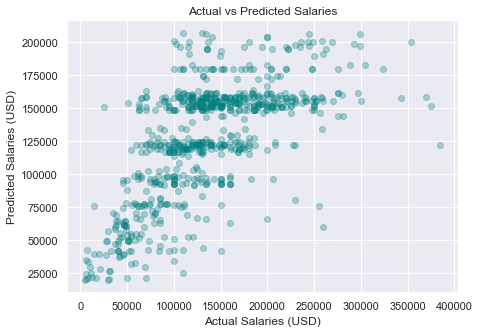

In [14]:
# ==========================================================
# STEP 13: Plot Actual vs Predicted
# ==========================================================
plt.figure(figsize=(7,5))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.3, color='teal')
plt.xlabel("Actual Salaries (USD)")
plt.ylabel("Predicted Salaries (USD)")
plt.title("Actual vs Predicted Salaries")
plt.show()


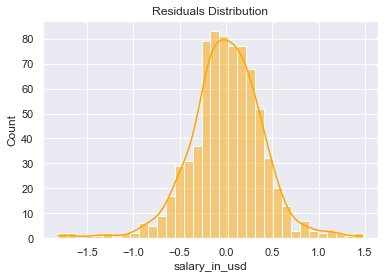

In [15]:
# ==========================================================
# STEP 14: Residual Distribution
# ==========================================================
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, color='orange')
plt.title("Residuals Distribution")
plt.show()

In [16]:
# ==========================================================
# STEP 15: Regularization Comparison
# ==========================================================
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

print("\n--- Regularization Comparison ---")
print(f"Ridge R²: {ridge.score(X_test, y_test):.4f}")
print(f"Lasso R²: {lasso.score(X_test, y_test):.4f}")



--- Regularization Comparison ---
Ridge R²: 0.5552
Lasso R²: 0.5539


In [17]:
# ==========================================================
# STEP 16: Feature Importance
# ==========================================================
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lin_reg.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nTop 10 Positive Predictors:\n", coef_df.head(10))
print("\nTop 10 Negative Predictors:\n", coef_df.tail(10))


Top 10 Positive Predictors:
                      Feature  Coefficient
25     employee_residence_US     1.291824
16     employee_residence_CA     1.124441
17     employee_residence_DE     0.888900
20     employee_residence_GB     0.858104
19     employee_residence_FR     0.527572
23  employee_residence_Other     0.459924
21     employee_residence_GR     0.411309
18     employee_residence_ES     0.386007
4         employment_type_FT     0.326341
24     employee_residence_PT     0.306552

Top 10 Negative Predictors:
                      Feature  Coefficient
3         employment_type_FL     0.078598
0                  work_year     0.031792
2               remote_ratio     0.008069
11  job_title_Data Scientist     0.007606
13           job_title_Other     0.002565
8   job_title_Data Architect     0.002195
9    job_title_Data Engineer    -0.013765
5         employment_type_PT    -0.178507
22     employee_residence_IN    -0.231598
7     job_title_Data Analyst    -0.251535
